**Authors:**
Jonas Juhler-Nøttrup (S164217), Niels Asp Fuglsang (S164181), Morten Wehlast Jørgensen (S147056), Jens Thuren Lindahl (S124347)

## 42186 Model-based Machine Learning - Bayesian Spatial Count

Research topic: How may we model non-linear dependencies on the inputs $\textbf{X}_n$?

More specifically, we wish to determine the advantages and disadvantages of the following approaches:
- Neural network 
- Hierarchical modelling

For each area $n$ in data set, we observe a count of injuries, $y_n$. 
The normal apprach is to assume linear dependence such that
$$
y_n \sim \text{NB}(r, p_n) \\
p_n= \frac{\exp(\psi_n)}{1+\exp(\psi_n)} \\
\psi_n = \beta^T\textbf{X}_n+\phi_n
$$

Where $\textbf{X}_n$ are the characteristics of the area and $\phi_n$ is a correlated error term with mean 0 and standard deviation $\sigma$.

### Load packages data

In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs
from torch import nn, Tensor
from torch import random, manual_seed
import torch.optim as optim

from sklearn import linear_model
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam

from src.utils import load_data

import random


In [2]:
# Set random seed (forproducability)
random.seed(0)
manual_seed(0)
torch.random.manual_seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)

In [3]:
# Load data
X, y, k, county_map, feat_names = load_data(impute=True)
X_train, X_test = X
y_train, y_test = y
k_train, k_test = k
print('Train:\nX-shape: {}, y-shape: {}'.format(X_train.shape, y_train.shape))
print('\nTest:\nX-shape: {}, y-shape: {}'.format(X_test.shape, y_test.shape))

Training:
X-shape: (1676, 38), y-shape: (1676,)

Testing:
X-shape: (419, 38), y-shape: (419,)


##### Prepare data for model.

In [4]:
# Standardize input features only using X_train
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

### Fitting a base model

In order to have a baseline, we produce a standard linear regression on the data.<br>
This will serve as a benchmark for evaluating how well the more complex models aid in predicting the number of accidents for  youths.

In [5]:
# Create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# Make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# Evaluate prediction accuracy
print("Baseline MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 3.30027249  7.4228757   4.50567392 14.34175354 15.8096688 ]
first 5 true values: [ 0  9  3 15 23]
Baseline MSE: 41.60316089247937


As we have a large number of variables in the model, we investigate whether all variables are significant.

In [6]:
# Test significance in our fit.
import statsmodels.api as sm

# Fit Ordinary Least Squares (OLS) model to the data.
X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     21.92
Date:                Thu, 27 May 2021   Prob (F-statistic):          2.94e-116
Time:                        00:56:36   Log-Likelihood:                -5376.6
No. Observations:                1676   AIC:                         1.083e+04
Df Residuals:                    1638   BIC:                         1.104e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.827      0.0

So only a very few number of parameters are significant. The model is heavily driven by bias and x1.<br>
Let's try only keeping 8 features based on Least Angle Regression Selection (LARS):

In [7]:
from sklearn import linear_model

# Get the 8 most significant features with Least Angle Regression
lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
linear_ids = lars.coef_ != 0
linear_ids = np.array([i for i, incl in enumerate(linear_ids) if incl])
print("Include ids: ", linear_ids)

Include ids:  [ 0  1  2  9 10 18 21 27]


In [8]:
# Fit new model with 8 most significant features
X2 = sm.add_constant(X_train[:, linear_ids])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     96.25
Date:                Thu, 27 May 2021   Prob (F-statistic):          1.07e-131
Time:                        00:56:36   Log-Likelihood:                -5395.4
No. Observations:                1676   AIC:                         1.081e+04
Df Residuals:                    1667   BIC:                         1.086e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.692      0.0

Notice that all variables might not still be significant, but this might change based on the train/test split. On could also use forward or backward feature selection for this matter.

In [9]:
# Create and fit regression model only using chosen features
lreg = linear_model.LinearRegression()
lreg.fit(X_train[:, linear_ids], y_train)

# Make predictions for test set
y_hat_lreg = lreg.predict(X_test[:, linear_ids])
print("First 5 predictions:", y_hat_lreg[:5])
print("First 5 true values:", y_test[:5])

# Evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

First 5 predictions: [ 5.20248878  6.68793155  4.45549343 14.572102   15.24162092]
First 5 true values: [ 0  9  3 15 23]
MSE: 41.434559241549906


A small improvement, but nothing impressive.

### Hierarchical model

In the hierarchical model, we seek to investigate whether some groups within the data may be more prone to accidents than others. By doing so, we hope to uncover certain findings in our data which allow us to get a better insight into the underlying patterns. Within our dataset we have the feature `County`, and we therefore choose to let our groups be defined by the counties. In total there are 5, distributed in the data as follows:

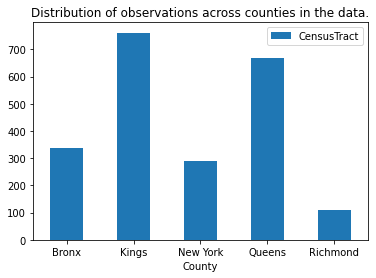

In [10]:
# Visualize number of observations for each county
df_census = pd.read_csv("data/nyc_census_tracts.csv")
fig, ax = plt.subplots(1,1)
df_census.groupby("County").count().plot.bar(y="CensusTract", ax=ax, rot=0)
plt.title("Distribution of observations across counties in the data.")
plt.show()

### Defining the model

The model will be based on the following generative process:

**Generative Process - Hierarchical model** 

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta_k|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}_n, \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

In [11]:
def hierarchical_model(X, k, n_k, obs=None, pred=False):
    
    # Number of observations and features
    N, n_feat = X.shape
    
    # Priors for distributions
    r_gamma1 = 2
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma))
    
    
    with pyro.plate("group", n_k):
        # Draw linear coefficient parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(n_feat), torch.ones(n_feat)).to_event()
        )
        
    with pyro.plate("observations", N):
        # Compute mean for psi-distribution with linear model
        psi_mu = torch.sum(X * beta[k], axis=1)
        
        # Sample psi (if-statement avoids use of posterior psi when predicting)
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
        
        # Sample prediction from negative binomial
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [12]:
# Prepare data for Pyro model by converting to tensors 
if not torch.is_tensor(X_train):
    X_train = torch.tensor(X_train).float()
    X_test  = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train).float()
    k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
    
# Add intercept
X_train = torch.cat((torch.ones(X_train.shape[0], 1), X_train), dim=-1)
X_test = torch.cat((torch.ones(X_test.shape[0], 1), X_test), dim=-1)    

# Get number of counties
n_k = len(np.unique(np.concatenate(k)))

In [13]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, k_train, n_k, y_train)
    
    # Display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh()

2000 ELBO: 5548.6: 100%|██████████| 2000/2000 [00:33<00:00, 60.04it/s]

CPU times: user 16.7 s, sys: 1.4 s, total: 18.1 s
Wall time: 33.4 s


### Visualizations of variable differences from county to county
We may now investigate how the intercept estimates differ across counties, to determine if any county is more dangerous than others.

In [14]:
from pyro.infer import Predictive
pyro.set_rng_seed(0)

predictive = Predictive(hierarchical_model, guide=guide, num_samples=1000,
                        return_sites=("beta", "r", "pred", "sigma"))
samples = predictive(X_train, k_train, n_k, y_train)

# Predict for X_test by passing through the model using the posterior
preds = predictive(X_test, k_test, n_k, pred=True)

/Users/jenslindahl/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jenslindahl/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jenslindahl/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

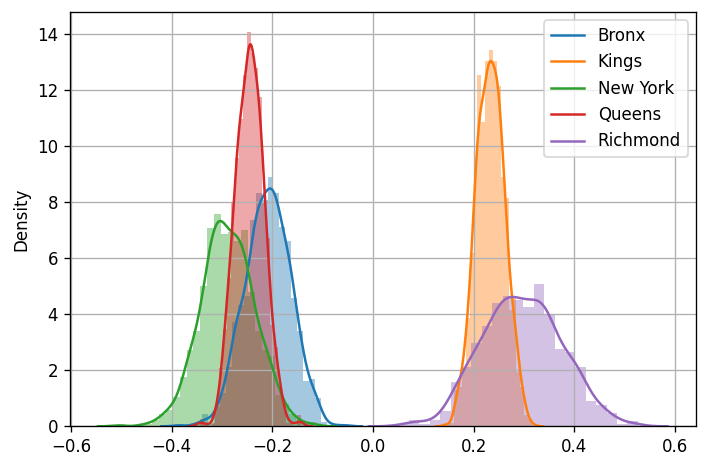

In [15]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
fig.set_dpi(120)

beta_samples = samples["beta"].detach().numpy()
beta_index = 0
for k_ in range(n_k):
    sns.distplot(beta_samples[:,k_,beta_index])
plt.legend([f"%s" % county_map[c] for c in range(n_k)])
# plt.title(f"Distribution of beta0  (Intercept)")

plt.grid(True)
fig.tight_layout()
fig.savefig('assets/dist_beta0_hier.jpg')
fig.show()

The plot show us that Kings and Richmond really stand out from the others and have a higher base number of accidents happen.

### Predict with the model
We produce three estimates for the MSE; using the mean, the median and lastly samples from the posterior.

In [16]:
# Extract beta and r samples from posteriors
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()

# Predict by computing the mean of parameters and passing through NB dist
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = np.sum(beta[k_test] * X_test.numpy(), axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean) # Extract mean from NB dist and use as prediction
print("MSE   (mean):", sum((y_hat - y_test)**2)/len(y_hat))

# Predict by computing the median
beta = np.median(beta_samples, axis=0)
r = np.median(r_samples, axis=0)
psi = np.sum(beta[k_test] * X_test.numpy(), axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
print("MSE (median):", sum((y_hat - y_test)**2)/len(y_test))

# Predictions obtained by sampling from the NB dist.
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (predictive):", sum((y_hat - y_test)**2)/len(y_test))

MSE   (mean): 47.48072717246438
MSE (median): 47.74589432541023
MSE (predictive): 58.515581266279334


In this case we see that using the estimate produced by the mean achieves the smallest MSE. Still, the model does not perform better than the linear regression as seen in the two comparison plots below.

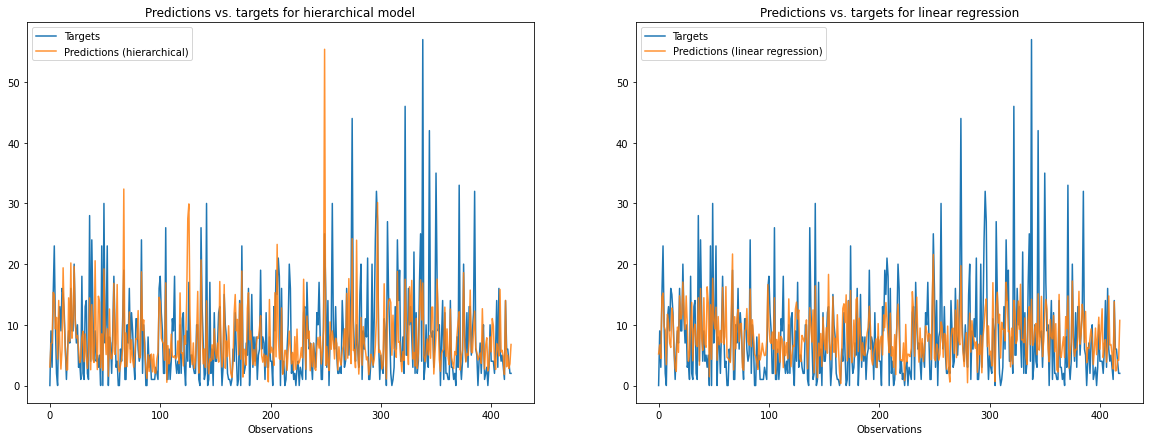

In [17]:
# Visualize predictions from the hierarchical model and linear regression
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for hierarchical model")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

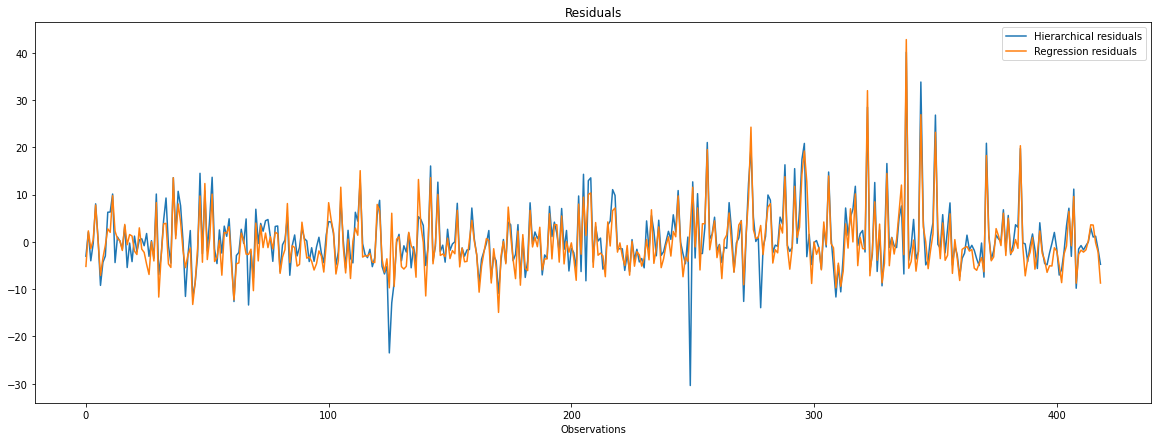

In [18]:
# Visualize residuals for both models
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.title("Residuals")
plt.show()

## Combining the neural network model and the hierarchical model

We saw that neither the neural network nor the hierarchical model managed to outperform the linear regression. <br>
Therefore, we try to combine the two models. We select a subset of features $\textbf{X}' \subseteq \textbf{X}$ which will be modelled using the hierarchical parameter vector $\beta_k$ and the complement of the set $\textbf{X} \backslash \textbf{X}' = \textbf{X}^*$ which will then go into the neural network. This gives us the following generative process

**Generative Process - Hierarchical model + neural network**
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> Draw coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

#### Splitting up the features

In order to determine which features go into $\textbf{X}'$ and which go into $\textbf{X}^*$, we will use the features selected by the LARS-algorithm in the hierarchical part of the model, and the remainder in the neural net.

In [19]:
print("Features in X':")
print("-"*15)
for idx in linear_ids:
    print(feat_names[idx])
    
# Shift by 1 to account for intercept
linear_ids = [0, *(linear_ids + 1)]

Features in X':
---------------
youth_pop_5to18
commute_priv_vehicle
med_hhincome
White
Black
Poverty
Service
Transit


In [20]:
def hierarchical_nn_model(X, linear_ids, k, n_k, obs=None, pred=False):
    # Number of observations
    N, lin_feat = X[:, linear_ids].shape
    nn_feat = X.shape[1]
    
    # Prior parameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Draw parameters for artificial neural network with 2 hidden layers
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(nn_feat, 8), torch.ones(nn_feat, 8)).to_event()) # input to hidden
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), torch.ones(8)).to_event()) # bias
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), torch.ones(8, 4)).to_event()) # hidden to hidden 
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), torch.ones(4)).to_event()) # bias
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), torch.ones(4, 1)).to_event()) # hidden to output
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)).to_event()) # bias
    
    with pyro.plate("group", n_k):
        # Draw linear coefficient parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(lin_feat), torch.ones(lin_feat)).to_event()
        )
    
    with pyro.plate("data", N):
        # NN forward pass
        x_nn = torch.relu(torch.matmul(X, w1) + b1)
        x_nn = torch.relu(torch.matmul(x_nn, w2) + b2)
        x_nn = torch.matmul(x_nn, w3) + b3

        # Combine linear model and neural network (non linear)
        lin_contr = torch.sum(X[:, linear_ids] * beta[k], axis=1)
        psi_mu = lin_contr + x_nn.reshape(-1)
        
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [21]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(hierarchical_nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, linear_ids, k_train, n_k, y_train)
    
    # Display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh()

1000 ELBO: 5138.8: 100%|██████████| 1000/1000 [00:44<00:00, 22.36it/s]

CPU times: user 28.3 s, sys: 1.26 s, total: 29.6 s
Wall time: 44.8 s


#### Predict with the model

In [22]:
# Collect samples from model in order to visualize parameters
pyro.set_rng_seed(0)
predictive = Predictive(hierarchical_nn_model, guide=nn_guide, num_samples=1000,
                        return_sites=())
samples = predictive(X_train, linear_ids, k_train, n_k)

# Predict for X_test by passing through the model using the posterior
preds = predictive(X_test, linear_ids, k_test, n_k, pred=True)

In [23]:
# Extract beta, r and nn parameter samples from posteriors
beta = samples["beta"].detach().numpy().mean(axis=0)
r = samples["r"].detach().numpy().mean(axis=0)
w1 = samples["w1"].mean(axis=0)
b1 = samples["b1"].mean(axis=0)
w2 = samples["w2"].mean(axis=0)
b2 = samples["b2"].mean(axis=0)
w3 = samples["w3"].mean(axis=0)
b3 = samples["b3"].mean(axis=0)


# Predict by computing the mean of parameters and passing through NB dist
# NN forward pass 
x_test_nn = torch.matmul(torch.relu(torch.matmul(torch.relu(torch.matmul(X_test, w1) + b1), w2) + b2), w3) + b3

# Propagate through rest of model
psi = np.sum(beta[k_test] * X_test.numpy()[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# Evaluate prediction accuracy
print("MSE (mean):", sum((y_hat - y_test)**2)/len(y_hat))

# Predict by computing the median
beta = np.median(samples["beta"].detach().numpy(), axis=0)
r = np.median(samples["r"].detach().numpy(), axis=0)
psi = np.sum(beta[k_test] * X_test.numpy()[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# Evaluate prediction accuracy
print("MSE (median):", sum((y_hat - y_test)**2)/len(y_hat))

# Predictions obtained by sampling from the NB dist.
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (predictive):", sum((y_hat - y_test)**2)/len(y_test))


MSE (mean): 40.96648492378472
MSE (median): 40.95251997415952
MSE (predictive): 41.488369546085565


This time we finally end up beating the linear regression! On top of that, the model has maintained its interpretability through the hierarchical modelling aspect.

/Users/jenslindahl/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jenslindahl/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jenslindahl/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

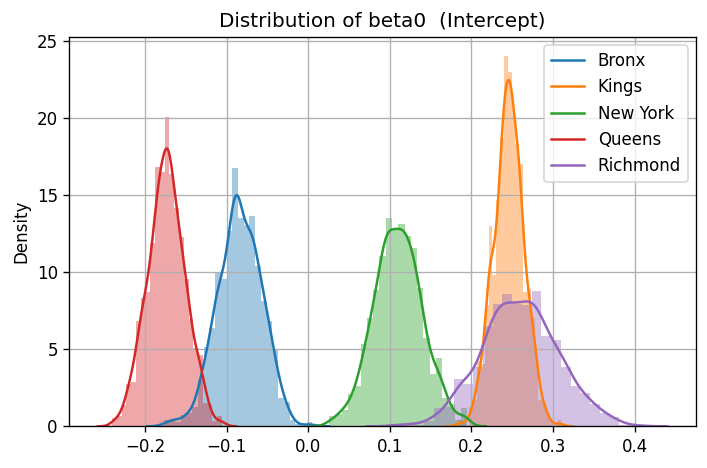

In [24]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
fig.set_dpi(120)

beta_index = 0
for k_ in range(n_k):
    sns.distplot(beta_samples[:, k_, beta_index])
plt.legend([f"%s" % county_map[c] for c in range(n_k)])
plt.title(f"Distribution of beta0  (Intercept)")

plt.grid(True)
fig.tight_layout()
fig.savefig('assets/dist_beta0_combined.jpg')
fig.show()

Kings and Richmond still have positive intercepts, however the model has now reduced the intercept vastly for Kings, while Richmond is more or less unchanged.

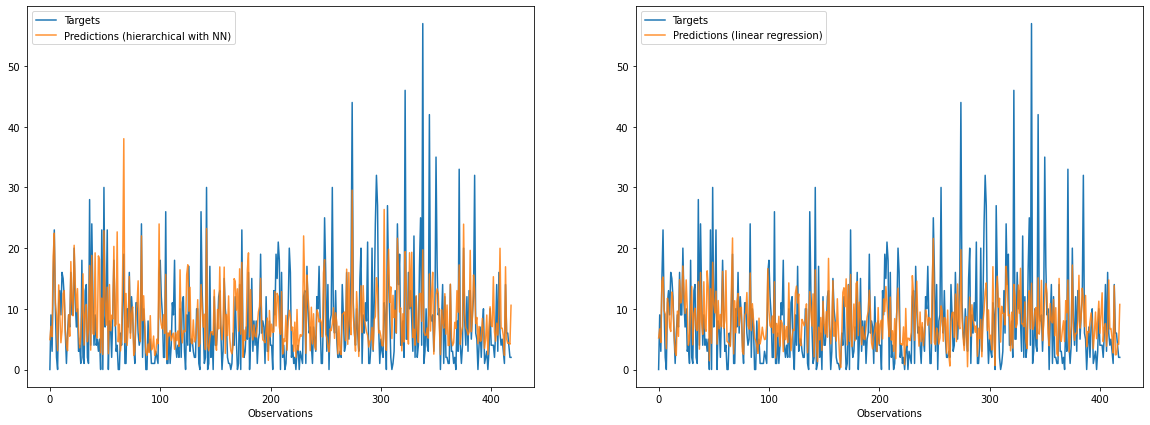

In [25]:
# Visualize predictions from the combined model and linear regression
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical with NN)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

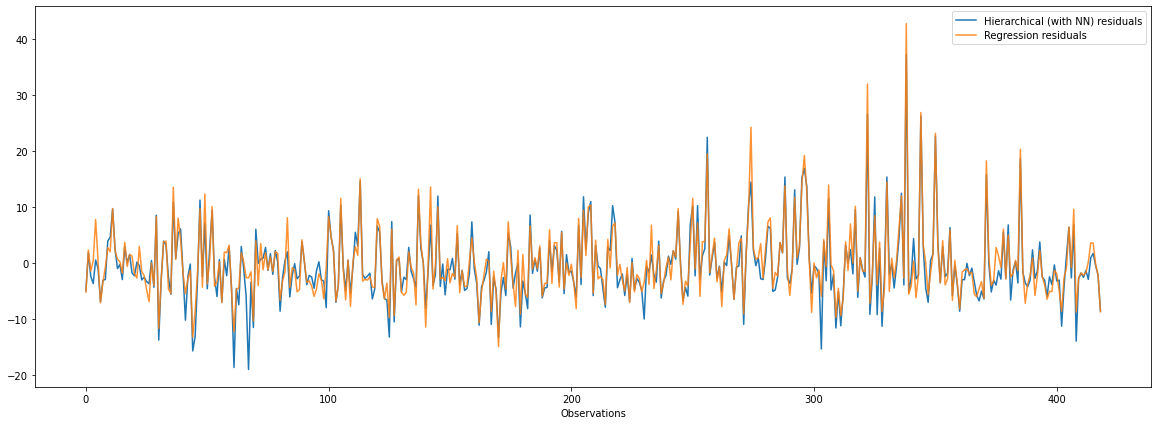

In [26]:
# Visualize residuals for both models
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical (with NN) residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals", alpha=0.85)
ax.legend()
ax.set_xlabel("Observations")
plt.plot()

### Autoencoder

We see that only one of the models produced manage to beat the baseline model. As feature selection is an art in itself, we now seek to reduce the dimensionality of our data by searching for some latent representation of the variables that may provide us with fewer variables and hopefully less noise.<br>
In doing so, we first develop an Autoencoder to encode the data and reduce the dimensionality. Let $f_{ae}$ denote a mapping produced by the autoencoder from our feature space of dimension $m$ to the outspace of the encoded data, with dimensionality $p < m$,
$$
f_{ae}: \mathbb{R}^m \mapsto \mathbb{R}^p.
$$

We then try to estimate $\psi_n$ as

$$
\psi_n = \beta^T f_{ae}(\textbf{X}_n) + \phi_n.
$$

The parameter estimates are then obtained through the following generative process (notice that data may be encoded before running the sampling).

**Generative Process - Autoencoder** 

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> Draw linear coefficients $\beta \sim N(\beta|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^Tf_{ae}(\textbf{X}_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

#### Determining a suitable output space

Before we may encode the data, we must first find a suitable value for $p$. This is done by searching for a value of p where the data we first encode, and the decode, is as close to the original data as possible. We find that $p=18$ to be the best of the tested values, effectively cutting the number of variables in half for our final model.

Note: the training of the autoencoder is done in the file `autoencoder.ipynb`. Here we will simply import the pretrained model.

In [27]:
class Autoencoder(nn.Module):
    
    """An autoencoder"""
    
    
    def __init__(self, input_shape, latent_features):
        super(Autoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=latent_features)
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=self.observation_features)
        )        

    def forward(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)

        y = self.decoder(h)
        
        return h, y
    
    def encode(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)
        
        return h

In [28]:
# Dimensionality of latent space (hyperparameter)
latent_features = 18
ae = Autoencoder(X_train.shape[1], latent_features)
print(ae)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=39, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): Tanh()
    (4): Linear(in_features=24, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=24, bias=True)
    (1): Tanh()
    (2): Linear(in_features=24, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=39, bias=True)
  )
)


### Using the autoencoder in a model

In [29]:
def ae_model(X_latent, obs=None, pred=False):
    # Initialize the neural network from PyTorch
    N, n_latent = X_latent.shape

    beta_mu = 0
    beta_sigma = 1
    
    beta = pyro.sample(
            "beta",
            dist.Normal(beta_mu*torch.ones(n_latent), beta_sigma*torch.ones(n_latent)).to_event()
        )
    
    # Hyperparameters
    r_gamma1 = 0.5
    r_gamma2 = 1
    
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))


    # The generative process
    if beta.dim() > 1:
        beta = torch.reshape(beta, (n_latent,))
    
    with pyro.plate("data", N):
        psi_mu = torch.matmul(X_latent, beta)

        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
        return pred
    return pred

In [30]:
# Define guide function
guide = AutoDiagonalNormal(ae_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 1000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(ae_model, guide, optimizer, loss=elbo)

# Prepare data
if not torch.is_tensor(X_train) or not torch.is_tensor(X_test):
    X_train = torch.tensor(np.array(X_train)).float()
    X_test = torch.tensor(np.array(X_test)).float()
    y_train = torch.tensor(y_train).float()    

# Encode data
with torch.no_grad():
    X_train_l = ae.encode(X_train)
    X_test_l = ae.encode(X_test)
    
# Add intercept
#X_train_l = torch.cat((torch.ones(X_train_l.shape[0], 1), X_train_l), dim=-1)
#X_test_l = torch.cat((torch.ones(X_test_l.shape[0], 1), X_test_l), dim=-1)


# Do gradient steps
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train_l, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

1000 ELBO: 5146.5: 100%|██████████| 1000/1000 [00:13<00:00, 76.01it/s]


In [31]:
# Get posterior samples for beta
predictive = Predictive(
    ae_model,
    guide=guide,
    num_samples=1000,
    return_sites=("beta", "r", "pred")
)
samples = predictive(X_train_l, y_train)
preds = predictive(X_test_l, pred=True)

In [32]:
# Predictions
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (autoencoder model):", sum((y_hat - y_test)**2)/len(y_test))

MSE (autoencoder model): 45.69887503866572


The MSE shows us that working with a latent representation of the variables does not provide any advantage over the linear regression.

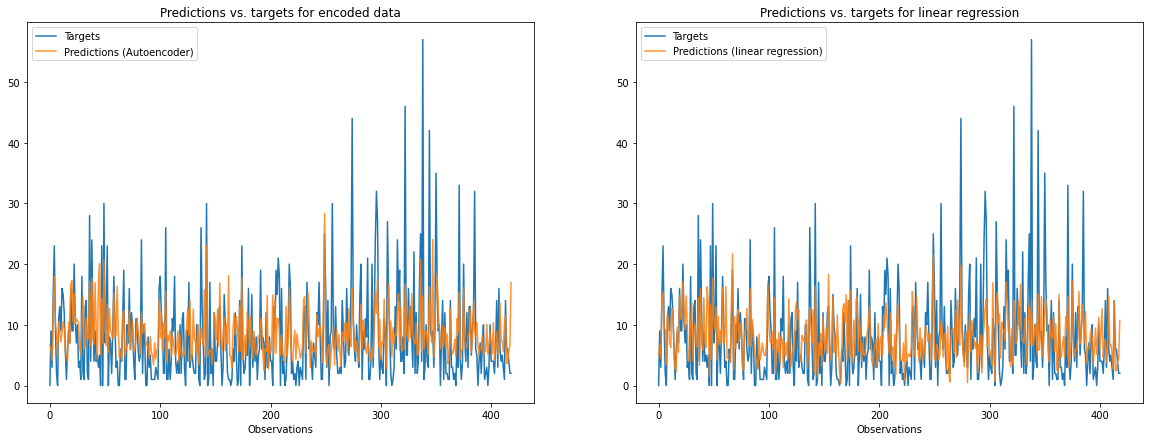

In [33]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (Autoencoder)", alpha=0.85)
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for encoded data")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)", alpha=0.85)
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

[]

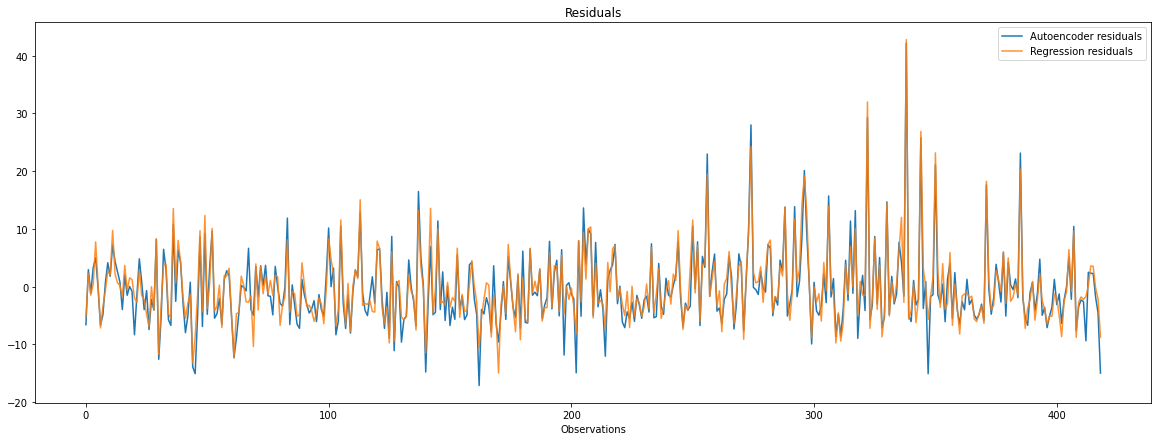

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Autoencoder residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals", alpha=0.85)
ax.legend()
ax.set_xlabel("Observations")
plt.title("Residuals")
plt.plot()